## Create Dataset

In [1]:
import torch
from torch.utils.data import Dataset

import numpy as np
import csv


class StockDataset(Dataset):
    ''' Dataset for loading and preprocessing the dataset '''
    def __init__(self,
                 path,
                 mode='train'
              ):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
          data = list(csv.reader(fp))
          data = np.array(data[1:])[:, 4:].astype(float)
        
        target = data[:, -1]
        data = data[:, list(range(7))]

        if mode == 'test':
            # Testing data
            self.data = torch.FloatTensor(data)
            self.target = torch.LongTensor(target)
        else:
            # Training data (train/dev sets)
        
            # Splitting training data into train & dev sets
            gap = int(len(data) * 0.8)
            if mode == 'train':
                
                self.data = torch.FloatTensor(data[:gap])
                self.target = torch.LongTensor(target[:gap])
            elif mode == 'dev':
                            
            # Convert data into PyTorch tensors
                self.data = torch.FloatTensor(data[gap:])
                self.target = torch.LongTensor(target[gap:])

        # Normalize features
        self.data = \
            (self.data - self.data.mean(dim=0, keepdim=True)) \
            / self.data.std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print(f'Finished reading the {mode} set of Dataset ({len(self.data)} samples found, each dim = {self.dim})')

    def __getitem__(self, index):

        return self.data[index], self.target[index]

    def __len__(self):

        return len(self.data)


## Create Model

In [2]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.layer1 = nn.Linear(7, 512)
        self.layer1_bn=nn.BatchNorm1d(512)

        self.layer2 = nn.Linear(512, 256)
        self.layer2_bn=nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 128)
        self.layer3_bn=nn.BatchNorm1d(128)

        self.layer4 = nn.Linear(128, 64)
        self.layer4_bn=nn.BatchNorm1d(64)

        self.layer5 = nn.Linear(64, 32)
        self.layer5_bn=nn.BatchNorm1d(32)

        self.drop = nn.Dropout(0.5)

        self.out = nn.Linear(32, 3) 

        # self.act_fn = nn.Sigmoid()
        self.act_fn = nn.ReLU()
        

    def forward(self, x):
        # x = self.drop(x)

        x = self.layer1(x)
        x = self.layer1_bn(x)
        x = self.act_fn(x)
        # x = self.drop(x)

        x = self.layer2(x)
        x = self.layer2_bn(x)
        x = self.act_fn(x)
        # x = self.drop(x)

        x = self.layer3(x)
        x = self.layer3_bn(x)
        x = self.act_fn(x)
        # x = self.drop(x)
 
        x = self.layer4(x)
        x = self.layer4_bn(x)
        x = self.act_fn(x)
        # x = self.drop(x)

        x = self.layer5(x)
        x = self.layer5_bn(x)
        x = self.act_fn(x)
        # x = self.drop(x)

        x = self.out(x)

        
        return x

## DataLoader

In [3]:
BATCH_SIZE = 512

from torch.utils.data import DataLoader

train_set = StockDataset('./training_data_v2_1d.csv', mode = 'test')
val_set = StockDataset('./testing_data_v2_1d.csv', mode = 'test')
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

Finished reading the test set of Dataset (425070 samples found, each dim = 7)
Finished reading the test set of Dataset (102360 samples found, each dim = 7)


## Training

In [4]:

#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# fix random seed for reproducibility
same_seeds(0)

# get device 
# device = get_device()
device = 'cpu'
print(f'DEVICE: {device}')

# training parameters
num_epoch = 400        # number of training epoch
early_stop = 99999999
learning_rate = 0.001       # learning rate

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

load_pretrained_model = False
activate_scheduler = False

DEVICE: cpu


In [5]:
def weighted_precision(y_true, y_predict):
    hit_count = {0: 0, 1: 0, 2: 0}

    for i, prediction in enumerate(y_predict):
        if y_true[i] == prediction:
            hit_count[prediction] += 1

    
    r1 = hit_count[0]/y_true.count(0)
    r2 = hit_count[1]/y_true.count(1)
    # r3 = hit_count[2]/y_true.count(2)

    p1 = hit_count[0]/y_predict.count(0)
    p2 = hit_count[1]/y_predict.count(1)
    p3 = hit_count[2]/y_predict.count(2)


    # a1 = hit_count[0]/up_down
    # a2 = hit_count[2]/down_up

    f1 = 2 * p1 * r1 / (p1 + r1)
    f2 = 2 * p2 * r2 / (p2 + r2)
    # f3 = 2 * p3 * r3 / (p3 + r3)
    
    return (p1 + p2 + p3) / 3

In [6]:
from sklearn.metrics import f1_score   

# train from pretrained model
if load_pretrained_model:
    model.load_state_dict(torch.load(model_path))

# Training

best_acc = 0.0
best_weighted_precision = 0.0
early_stop_cnt = 0

acc_record = {'train': [], 'dev': []}
macro_f1_record = {'train': [], 'dev': []}
weighted_score_record = {'train': [], 'dev': []}

# init accuracy
train_acc = 0.0
val_acc = 0.0

train_labels = []
train_predictions = []
val_labels = []
val_predictions = []
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, val_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        val_acc += (val_pred.cpu() == labels.cpu()).sum().item() 
        for y in val_pred.cpu().numpy():
            val_predictions.append(y)

        for y in labels.cpu().numpy():
            val_labels.append(y)
      
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs) 
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        train_acc += (train_pred.cpu() == labels.cpu()).sum().item() 
        for y in train_pred.cpu().numpy():
            train_predictions.append(y)

        for y in labels.cpu().numpy():
            train_labels.append(y)

    acc_record['dev'].append(val_acc/len(val_set))
    acc_record['train'].append(train_acc/len(train_set))
    macro_f1_record['dev'].append(f1_score(val_labels, val_predictions, average='macro'))
    macro_f1_record['train'].append(f1_score(train_labels, train_predictions, average='macro'))
    weighted_score_record['dev'].append(weighted_precision(val_labels, val_predictions))
    weighted_score_record['train'].append(weighted_precision(train_labels, train_predictions))

# start training
for epoch in range(num_epoch):
  
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    train_labels = []
    train_predictions = []
    val_labels = []
    val_predictions = []

    # training
    model.train() # set the model to training mode
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward() # compute gradient
        optimizer.step() # update model with optimizer

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()
        for y in train_pred.cpu().numpy():
            train_predictions.append(y)

        for y in labels.cpu().numpy():
            train_labels.append(y)

    
    acc_record['train'].append(train_acc/len(train_set))

    train_f1 = f1_score(train_labels, train_predictions, average='macro')
    macro_f1_record['train'].append(train_f1)

    train_weighted_precision = weighted_precision(train_labels, train_predictions)
    weighted_score_record['train'].append(train_weighted_precision)

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() 
                val_loss += batch_loss.item()
                for y in val_pred.cpu().numpy():
                    val_predictions.append(y)

                for y in labels.cpu().numpy():
                    val_labels.append(y)


            acc_record['dev'].append(val_acc/len(val_set))

            val_f1 = f1_score(val_labels, val_predictions, average='macro')
            macro_f1_record['dev'].append(val_f1)

            val_weighted_precision = weighted_precision(val_labels, val_predictions)
            weighted_score_record['dev'].append(val_weighted_precision)


            # if the model improves, save a checkpoint at this epoch
            if val_weighted_precision > best_weighted_precision:
                best_weighted_precision = val_weighted_precision
                torch.save(model.state_dict(), model_path)
                print('[{:03d}/{:03d}] Train Acc: {:3.6f} F1: {:.3f} wP: {:.3f} Loss: {:3.6f} | \
                Val Acc: {:3.6f} F1: {:.3f} wP: {:.3f} loss: {:3.6f}'
                      .format(epoch + 1, num_epoch, train_acc/len(train_set), train_f1, train_weighted_precision, train_loss/len(train_loader), 
                                                val_acc/len(val_set), val_f1, val_weighted_precision, val_loss/len(val_loader)))
                # print('saving model with Val Acc {:.3f}'.format(best_acc/len(val_set)))
                print('saving model with Val Precision {:.3f}'.format(best_weighted_precision))
                early_stop_cnt = 0
            else:
                early_stop_cnt += 1
    # else:
    #     print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
    #         epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
    #     ))
    
    # early stop
    if early_stop_cnt > early_stop:
      print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))
      break

    if epoch % 10 == 0 and epoch != 0:
        print(f'epoch {epoch} | train acc : {train_acc/len(train_set)}')
    
    # lr schedule
    if activate_scheduler:
        scheduler.step()

# if not validating, save the last epoch
torch.save(model.state_dict(), './last_model.ckpt')
print('saving model at last epoch')
  


[001/400] Train Acc: 0.386887 F1: 0.376 wP: 0.386 Loss: 1.087105 |                 Val Acc: 0.378419 F1: 0.353 wP: 0.378 loss: 1.090686
saving model with Val Precision 0.378
[003/400] Train Acc: 0.398659 F1: 0.391 wP: 0.398 Loss: 1.081886 |                 Val Acc: 0.383656 F1: 0.351 wP: 0.387 loss: 1.089114
saving model with Val Precision 0.387
epoch 10 | train acc : 0.4073046792293034
[012/400] Train Acc: 0.407387 F1: 0.401 wP: 0.407 Loss: 1.077272 |                 Val Acc: 0.387143 F1: 0.360 wP: 0.391 loss: 1.088270
saving model with Val Precision 0.391
epoch 20 | train acc : 0.41230385583550944
epoch 30 | train acc : 0.4165196320606018
epoch 40 | train acc : 0.42067894699696523
epoch 50 | train acc : 0.4258428023619639
epoch 60 | train acc : 0.43135483567412425
epoch 70 | train acc : 0.43607876349777686
epoch 80 | train acc : 0.4406897687439716
epoch 90 | train acc : 0.44624650057637566
epoch 100 | train acc : 0.45040581551273906
epoch 110 | train acc : 0.45466158515068106
epoch 1

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_learning_curve(acc_record, title='', y_label=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_epoch = len(acc_record['train'])
    x = range(total_epoch)
    # x_2 = x_1[::len(acc_record['train']) // len(acc_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x, acc_record['train'], c='tab:red', label='train')
    plt.plot(x, acc_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.33, 0.55)
    plt.xlabel('Training Epoch')
    plt.ylabel(y_label)
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

In [8]:
temp = {'train': weighted_score_record['train'][:100], 'dev': weighted_score_record['dev'][:100]}

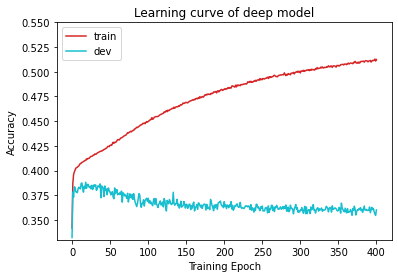

In [9]:
plot_learning_curve(acc_record, title = 'deep model', y_label = 'Accuracy')

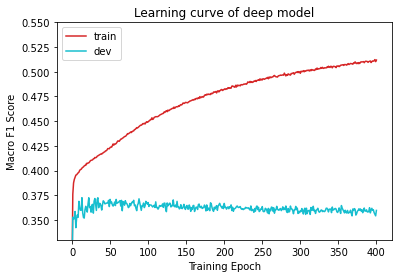

In [10]:
plot_learning_curve(macro_f1_record, title = 'deep model', y_label = 'Macro F1 Score')

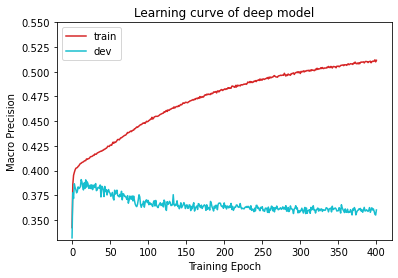

In [11]:
plot_learning_curve(weighted_score_record, title = 'deep model', y_label = 'Macro Precision')

In [12]:
print('train acc')
print(acc_record['train'][-100])
print(acc_record['train'][-40])
print(acc_record['train'][-20])
print(acc_record['train'][-10])
print(acc_record['train'][-5])
print(acc_record['train'][-1])


train acc
0.5009222010492389
0.5071799938833604
0.5103794669113323
0.5111252264332934
0.5112593219940245
0.5123932528759969


## Testing

In [13]:
# from sklearn.metrics import f1_score
# device = 'cpu'
# model_path = './models/macro_precision/30d/model.ckpt'

In [14]:
# create testing dataset
# test_set = StockDataset('./testing_data.csv', mode = 'test')
# test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

model.eval() # set the model to evaluation mode
with torch.no_grad():
  test_acc = 0.0
  predict = []
  label = []
  for data in val_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs) 
    _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

    test_acc += (test_pred.cpu() == labels.cpu()).sum().item() 

    for y in test_pred.cpu().numpy():
      predict.append(y)

    for y in labels.cpu().numpy():
      label.append(y)

print(f'Test Acc: {test_acc / len(val_set)}')

Test Acc: 0.3871434153966393


In [15]:
print('pred', 'real')
print(predict.count(0), label.count(0))
print(predict.count(1), label.count(1))
print(predict.count(2), label.count(2))


pred real
25265 34120
60806 34120
16289 34120


In [16]:
hit_count = {0: 0, 1: 0, 2: 0}
for i, prediction in enumerate(predict):
  if label[i] == prediction:
    hit_count[prediction] += 1


In [17]:
import math

def percent(x):
    return math.ceil(x * 100)

print('Accuracy')
acc = (hit_count[0] + hit_count[1] + hit_count[2]) / (label.count(0) + label.count(1) + label.count(2))
print(acc)

print('\nRecall')
r1 = hit_count[0]/label.count(0)
r2 = hit_count[1]/label.count(1)
r3 = hit_count[2]/label.count(2)
# print(percent(r1), percent(r2), percent(r3))
print(r1, r2, r3)

print('\nPrecision')
p1 = hit_count[0]/predict.count(0)
p2 = hit_count[1]/predict.count(1)
p3 = hit_count[2]/predict.count(2)
# print(percent(p1), percent(p2), percent(p3))
print(p1, p2, p3)

print('\nF1 score')
f1 = 2 * p1 * r1 / (p1 + r1)
f2 = 2 * p2 * r2 / (p2 + r2)
f3 = 2 * p3 * r3 / (p3 + r3)
# print(percent(f1), percent(f2), percent(f3))
print(f1, f2, f3)

print('\nmacro F1 score')
print((f1 + f2 + f3 )/ 3)

Accuracy
0.3871434153966393

Recall
0.28235638921453693 0.6846717467760844 0.1944021101992966

Precision
0.3813180288937265 0.38418906029010297 0.40720731782184294

F1 score
0.3244590384777301 0.49219391947411667 0.26316729155507945

macro F1 score
0.3599400831689754


In [18]:
print(f1_score(label, predict, average='macro'))
print()
# print(f1_score(label, predict, average='weighted'))
# print()

# print(f1_score(label, predict, average='micro'))
# print()


0.3599400831689754



## Confusion Matrix

In [19]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    # plt.xlabel(f'Predicted label\naccuracy={accuracy}')
    plt.xlabel('Predicted label')
    plt.show()

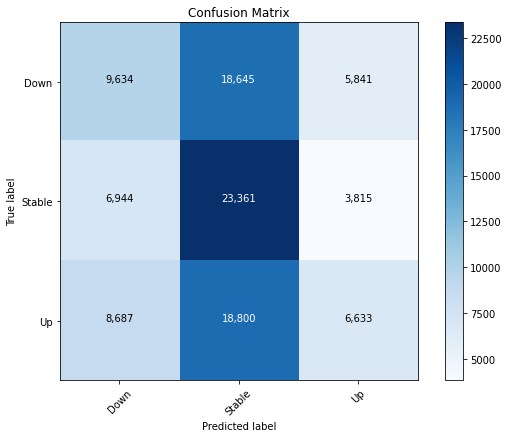

In [20]:
from sklearn.metrics import confusion_matrix


plot_confusion_matrix(cm           = confusion_matrix(label, predict),
                      normalize    = False,
                      target_names = ['Down', 'Stable' ,'Up'],
                      title        = "Confusion Matrix")                          